# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [69]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/asl_data/'
DATA_PATH = 'C:/Users/jarit/Downloads/asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [71]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Importar Images

In [4]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [5]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    n_samples = len(x)
    indices = np.arange(n_samples)
    
    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)
    
    split_idx = int(n_samples * pct)
    
    x_val_split = x[indices[:split_idx]]
    y_val_split = y[indices[:split_idx]]
    x_test_split = x[indices[split_idx:]]
    y_test_split = y[indices[split_idx:]]
    
    return x_val_split, y_val_split, x_test_split, y_test_split

In [7]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)
print(f"Validation data shape: {x_val.shape}")
print(f"Test data shape: {x_test.shape}")

Validation data shape: (1793, 784)
Test data shape: (1793, 784)


In [72]:
### The following

alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

print("Classes:", alphabet)

24
Classes: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


### Normalise

In [10]:
def normalize_data(x_train, x_val, x_test):
    # Normalizar a [0, 1]
    x_train = x_train / 255.0
    x_val = x_val / 255.0
    x_test = x_test / 255.0
    
    return x_train, x_val, x_test

x_train, x_val, x_test = normalize_data(x_train, x_val, x_test)
print("Data normalized to [0, 1] range")

Data normalized to [0, 1] range


### Graficar muestras

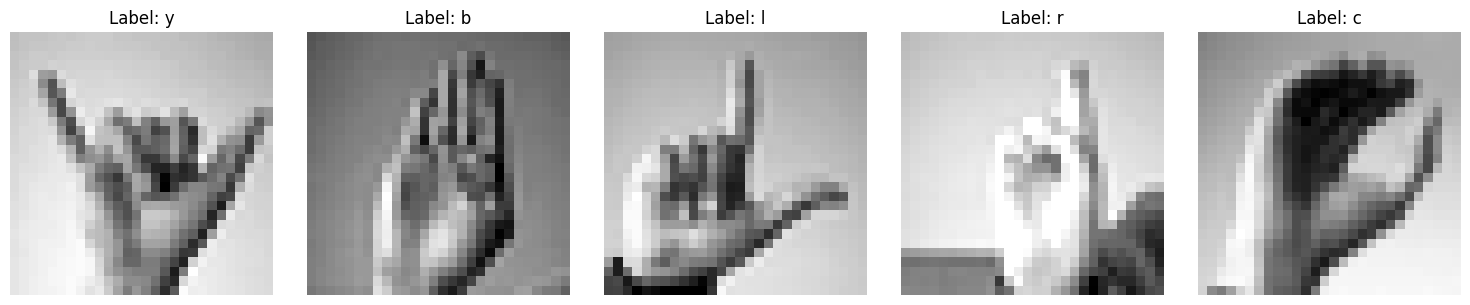

In [73]:
def plot_asl_samples(x_data, y_data, alphabet, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    indices = np.random.choice(len(x_data), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        img = x_data[idx].reshape(28, 28)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {alphabet[y_data[idx]]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_asl_samples(x_train, y_train, alphabet)

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

In [ ]:
def create_mini_batches(x, y, batch_size, shuffle=True):
    """
    Create mini-batches for training
    """
    n_samples = len(x)
    
    if shuffle:
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]
    
    mini_batches = []
    
    for i in range(0, n_samples, batch_size):
        x_batch = x[i:i + batch_size]
        y_batch = y[i:i + batch_size]
        mini_batches.append((x_batch, y_batch))
    
    return mini_batches

## Nuestra clase Linear, ReLU y Sequential

###  Clase Linear

In [14]:
### Clase Linear

class Linear:
    def __init__(self, input_dim, output_dim):
        """
        Inicializa la capa lineal
        """
        # Inicialización He (buena para ReLU)
        self.W = np.random.randn(output_dim, input_dim) * np.sqrt(2.0 / input_dim)
        self.b = np.zeros((output_dim, 1))
        
        # Gradientes
        self.dW = None
        self.db = None
        
        # Cache para backward pass
        self.cache = None
    
    def forward(self, x):
        """
        Forward pass: z = Wx + b
        """
        # x shape: (input_dim, batch_size) o (input_dim,)
        if x.ndim == 1:
            x = x.reshape(-1, 1)
        
        self.cache = x
        z = self.W @ x + self.b
        return z
    
    def backward(self, dz):
        """
        Backward pass: calcula dW, db, dx
        """
        x = self.cache
        
        # Gradientes
        self.dW = dz @ x.T
        self.db = np.sum(dz, axis=1, keepdims=True)
        dx = self.W.T @ dz
        
        return dx
    
    def update(self, learning_rate):
        """
        Actualiza parámetros usando gradiente descendiente
        """
        if self.dW is not None and self.db is not None:
            self.W -= learning_rate * self.dW
            self.b -= learning_rate * self.db

### Clase ReLU

In [15]:
class ReLU:
    def __init__(self):
        self.cache = None
    
    def forward(self, z):
        """
        Forward pass: a = max(0, z)
        """
        self.cache = z
        return np.maximum(0, z)
    
    def backward(self, da):
        """
        Backward pass: dz = da * (z > 0)
        """
        z = self.cache
        dz = da * (z > 0)
        return dz

### Clase Sequential

In [16]:
class Sequential:
    def __init__(self, layers):
        """
        Inicializa modelo secuencial con lista de capas
        """
        self.layers = layers
    
    def forward(self, x):
        """
        Forward pass a través de todas las capas
        """
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, dz):
        """
        Backward pass a través de todas las capas (en orden inverso)
        """
        for layer in reversed(self.layers):
            dz = layer.backward(dz)
        return dz
    
    def update(self, learning_rate):
        """
        Actualiza todos los parámetros del modelo
        """
        for layer in self.layers:
            if hasattr(layer, 'update'):
                layer.update(learning_rate)
    
    def predict(self, x):
        """
        Realiza predicción
        """
        # Asegurar que x tenga la forma correcta
        if x.ndim == 1:
            x = x.reshape(-1, 1)
        
        # Forward pass
        output = self.forward(x)
        
        # Para clasificación: obtener índice de clase con mayor probabilidad
        if output.shape[0] > 1:  # Si es multiclase
            return np.argmax(output, axis=0)[0]
        else:  # Si es binaria
            return 1 if output[0, 0] > 0.5 else 0
    
    def evaluate(self, x, y):
        """
        Evalúa el modelo en un conjunto de datos
        """
        correct = 0
        total = len(x)
        
        for i in range(total):
            xi = x[i].reshape(-1, 1)
            yi = y[i]
            
            pred = self.predict(xi)
            
            if pred == yi:
                correct += 1
        
        accuracy = correct / total
        return accuracy

### Cost Function

In [17]:
def softmax(z):
    """
    Función softmax estable numéricamente
    """
    # Restar el máximo para estabilidad numérica
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    """
    Pérdida de entropía cruzada
    """
    # Convertir y_true a one-hot encoding si es necesario
    if y_true.ndim == 1 or (y_true.ndim == 2 and y_true.shape[0] == 1):
        n_classes = y_pred.shape[0]
        n_samples = len(y_true) if y_true.ndim == 1 else y_true.shape[1]
        
        y_true_one_hot = np.zeros((n_classes, n_samples))
        
        if y_true.ndim == 1:
            y_true_one_hot[y_true, np.arange(n_samples)] = 1
        else:
            y_true_one_hot[y_true[0], np.arange(n_samples)] = 1
    else:
        y_true_one_hot = y_true
    
    # Calcular pérdida
    epsilon = 1e-15  # Para evitar log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    loss = -np.sum(y_true_one_hot * np.log(y_pred)) / y_pred.shape[1]
    return loss

def compute_gradients(y_pred, y_true):
    """
    Calcula gradiente inicial para backward pass
    """
    # Convertir y_true a one-hot encoding si es necesario
    if y_true.ndim == 1 or (y_true.ndim == 2 and y_true.shape[0] == 1):
        n_classes = y_pred.shape[0]
        n_samples = len(y_true) if y_true.ndim == 1 else y_true.shape[1]
        
        y_true_one_hot = np.zeros((n_classes, n_samples))
        
        if y_true.ndim == 1:
            y_true_one_hot[y_true, np.arange(n_samples)] = 1
        else:
            y_true_one_hot[y_true[0], np.arange(n_samples)] = 1
    else:
        y_true_one_hot = y_true
    
    # Gradiente de softmax + cross-entropy
    dz = y_pred - y_true_one_hot
    return dz

### Loop de entrenamiento

In [18]:
def train_model(model, x_train, y_train, x_val, y_val, 
                epochs=30, batch_size=64, learning_rate=0.001):
    """
    Función de entrenamiento del modelo
    """
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    n_samples = len(x_train)
    
    for epoch in range(epochs):
        # Crear mini-batches
        batches = create_mini_batches(x_train, y_train, batch_size)
        
        epoch_loss = 0
        correct_train = 0
        
        for x_batch, y_batch in batches:
            batch_loss = 0
            batch_correct = 0
            
            # Transponer para tener (features, batch_size)
            x_batch_t = x_batch.T
            y_batch_t = y_batch.reshape(1, -1)
            
            # Forward pass
            z_output = model.forward(x_batch_t)
            y_pred = softmax(z_output)
            
            # Calcular pérdida
            loss = cross_entropy_loss(y_pred, y_batch_t)
            batch_loss += loss
            
            # Calcular gradientes
            dz = compute_gradients(y_pred, y_batch_t)
            
            # Backward pass
            model.backward(dz)
            
            # Actualizar parámetros
            model.update(learning_rate)
            
            # Calcular precisión en batch
            predictions = np.argmax(y_pred, axis=0)
            batch_correct += np.sum(predictions == y_batch)
            
            epoch_loss += loss
            correct_train += batch_correct
        
        # Pérdida y precisión promedio en época
        avg_train_loss = epoch_loss / len(batches)
        train_accuracy = correct_train / n_samples
        
        # Validación
        val_accuracy = model.evaluate(x_val, y_val)
        
        # Calcular pérdida en validación
        x_val_t = x_val.T
        y_val_t = y_val.reshape(1, -1)
        z_val = model.forward(x_val_t)
        y_val_pred = softmax(z_val)
        val_loss = cross_entropy_loss(y_val_pred, y_val_t)
        
        # Guardar métricas
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        
        # Imprimir progreso
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{epochs}")
            print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
            print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
            print("-" * 50)
    
    return train_losses, val_losses, train_accs, val_accs

### Create your model and train it

In [19]:

# Crear modelo
input_dim = 784  # 28x28
hidden_dim1 = 512
hidden_dim2 = 256
output_dim = 24  # 24 letras (a-y, sin j ni z)

# Inicializar capas
layer1 = Linear(input_dim, hidden_dim1)
relu1 = ReLU()
layer2 = Linear(hidden_dim1, hidden_dim2)
relu2 = ReLU()
layer3 = Linear(hidden_dim2, output_dim)

# Crear modelo secuencial
model = Sequential([layer1, relu1, layer2, relu2, layer3])

print("Modelo creado exitosamente")
print(f"Arquitectura: {input_dim} -> {hidden_dim1} -> {hidden_dim2} -> {output_dim}")

Modelo creado exitosamente
Arquitectura: 784 -> 512 -> 256 -> 24


In [22]:
# Entrenar modelo
print("Iniciando entrenamiento...")
train_losses, val_losses, train_accs, val_accs = train_model(
    model, x_train, y_train, x_val, y_val,
    epochs=30, batch_size=64, learning_rate=0.001
)

print("\nEntrenamiento completado!")

Iniciando entrenamiento...
Epoch 5/30
  Train Loss: 0.4315, Train Acc: 0.8668
  Val Loss: 0.7267, Val Acc: 0.7563
--------------------------------------------------
Epoch 10/30
  Train Loss: 0.2036, Train Acc: 0.9545
  Val Loss: 0.5613, Val Acc: 0.8238
--------------------------------------------------
Epoch 15/30
  Train Loss: 0.0279, Train Acc: 0.9996
  Val Loss: 0.6034, Val Acc: 0.8321
--------------------------------------------------
Epoch 20/30
  Train Loss: 0.0067, Train Acc: 1.0000
  Val Loss: 0.6506, Val Acc: 0.8249
--------------------------------------------------
Epoch 25/30
  Train Loss: 0.0040, Train Acc: 1.0000
  Val Loss: 0.6805, Val Acc: 0.8243
--------------------------------------------------
Epoch 30/30
  Train Loss: 0.0028, Train Acc: 1.0000
  Val Loss: 0.6887, Val Acc: 0.8310
--------------------------------------------------

Entrenamiento completado!


### Test your model on Random data from your test set

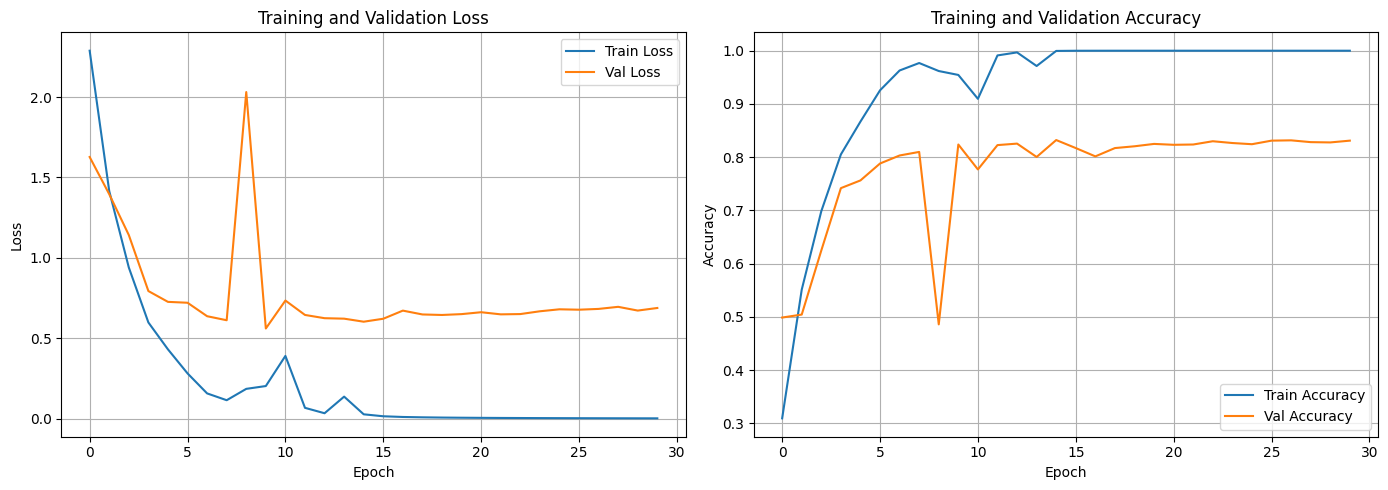

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.8310
Test Accuracy: 0.8288


In [23]:
# Visualizar resultados
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de pérdida
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Gráfico de precisión
axes[1].plot(train_accs, label='Train Accuracy')
axes[1].plot(val_accs, label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Imprimir métricas finales
print(f"Final Training Accuracy: {train_accs[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accs[-1]:.4f}")

# Evaluar en test set
test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

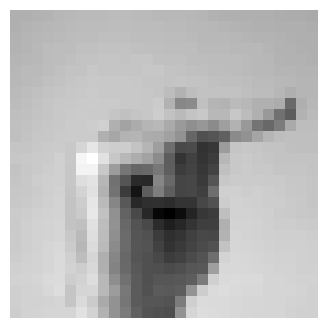

El valor predicho es: x
El valor real es: t


In [59]:
def plot_number(img_array):
    """
    Función para visualizar imagen ASL
    """
    plt.figure(figsize=(4, 4))
    plt.imshow(img_array.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()

# Probar con datos aleatorios
idx = np.random.randint(len(y_test))
plot_number(x_test[idx].reshape(28,28))
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'El valor predicho es: {alphabet[pred]}')
print(f'El valor real es: {alphabet[y_test[idx]]}')

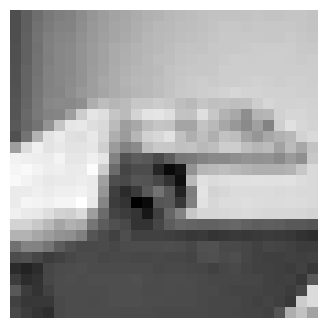

el valor predicho es: h el valor real es:h


In [62]:
idx = np.random.randint(len(y_test))
plot_number(x_test[idx].reshape(28,28))
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {alphabet[pred]} el valor real es:{alphabet[y_test[idx]]}')


Prueba con múltiples ejemplos:


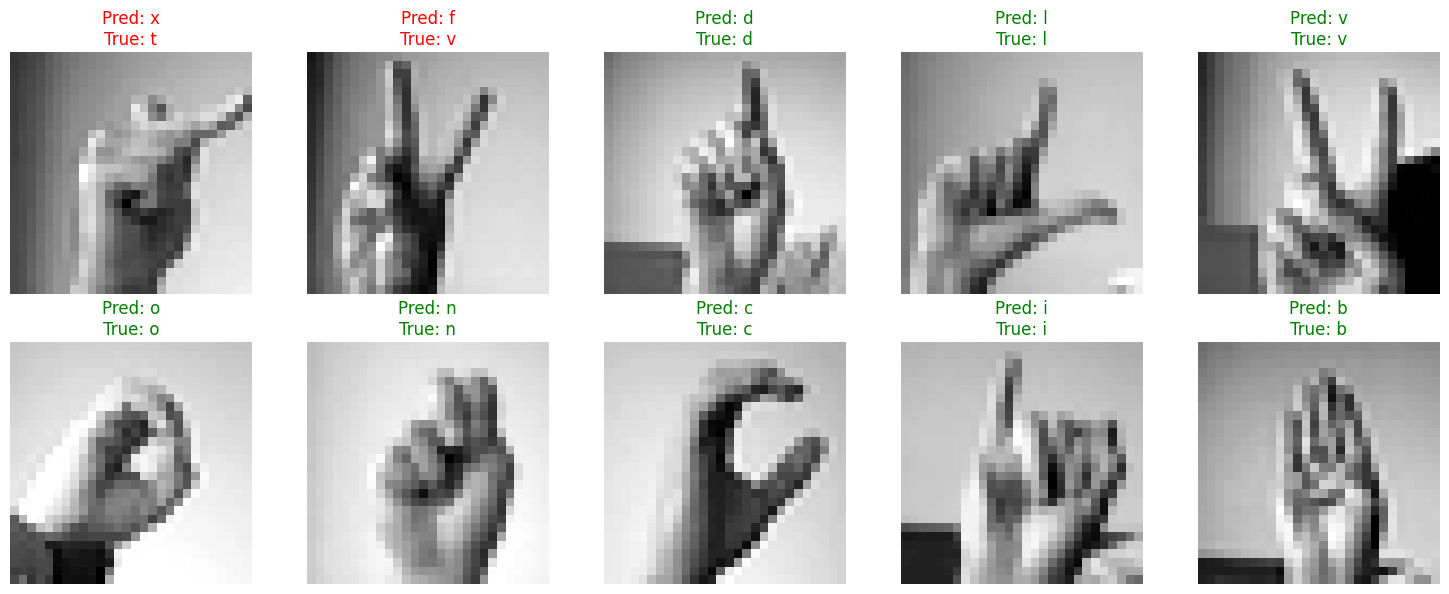


Precisión final en Test Set: 0.8288 (82.88%)


In [75]:
# Prueba adicional con múltiples ejemplos
print("\nPrueba con múltiples ejemplos:")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

indices = np.random.choice(len(y_test), 10, replace=False)

for i, idx in enumerate(indices):
    row = i // 5
    col = i % 5
    
    img = x_test[idx].reshape(28, 28)
    axes[row, col].imshow(img, cmap='gray')
    
    pred = model.predict(x_test[idx].reshape(-1, 1))
    true_label = y_test[idx]
    
    color = 'green' if pred == true_label else 'red'
    axes[row, col].set_title(f"Pred: {alphabet[pred]}\nTrue: {alphabet[true_label]}", color=color)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Calcular precisión en test set
test_accuracy = model.evaluate(x_test, y_test)
print(f"\nPrecisión final en Test Set: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
